In [83]:
!pip install tensorflow  tensorflow-datasets ipywidgets

In [84]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [85]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [86]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

ds = tfds.load('fashion_mnist', split='train')

## 2. Viz data and build dataset

In [87]:
import numpy as np

# set up connection aka iterator
dataiterator = ds.as_numpy_iterator()
# getting data out of pipeline
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

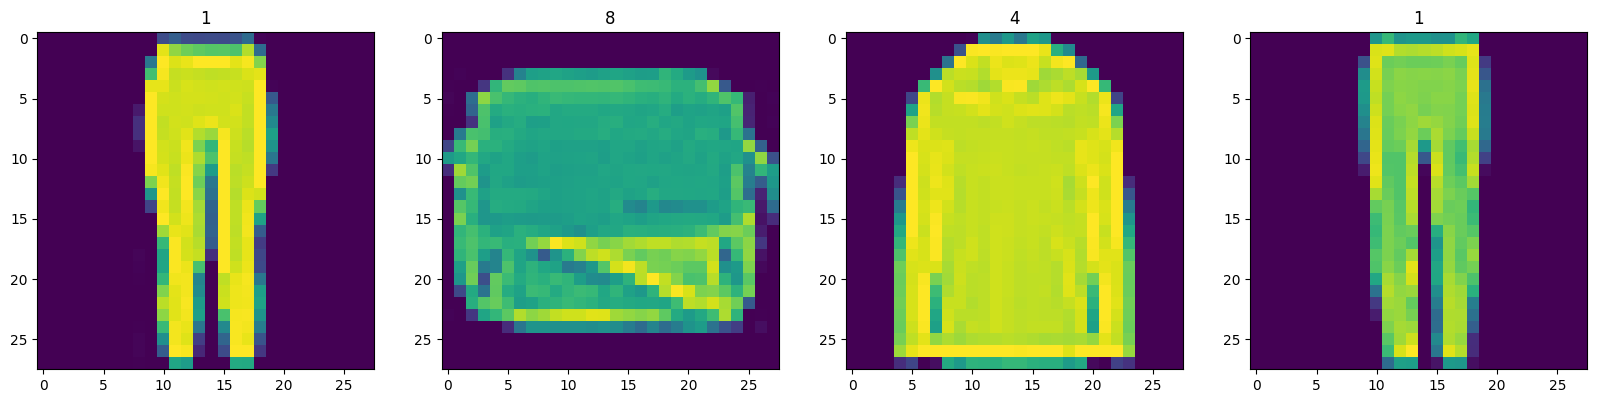

In [88]:
fig , ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
  #grab an image and label
  sample = dataiterator.next()
  # plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(sample['image']))
  # appending the image label as the plot title
  ax[idx].title.set_text(sample['label'])

In [89]:
# scale and return images only
def scale_images(data):
  image = data['image']
  return image / 255

In [90]:
ds = tfds.load('fashion_mnist', split='train')
# running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# cache the dataset for that batch
ds = ds.cache()
# shuffle it up
ds = ds.shuffle(60000)
# batch into 128 images per sample
ds = ds.batch(128)
# reduce the liklihood of bottlencking
ds = ds.prefetch(64)

In [91]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## 3. Build the Neural Network

### 3.1 Import modelling components

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build generator

In [93]:
from keras.src.metrics.confusion_metrics import activations
def build_generator():
  model = Sequential()

  # takes in random values and reshapes it to 7x7x128
  #beginnings of a renerated image
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # convolutional block 1
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # convolutional block 2
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # conv layer to get to one channel
  model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))


  return model

In [94]:
generator = build_generator()
generator.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 6272)              809088    
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_8 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_13 (UpSampli  (None, 14, 14, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                     

In [95]:
img = generator.predict(np.random.randn(4, 128,  1))
img

1/1 [==============================] - 0s 93ms/step


array([[[[0.49524894],
         [0.49500236],
         [0.49209994],
         ...,
         [0.48836225],
         [0.49432755],
         [0.49652022]],

        [[0.4984886 ],
         [0.49926406],
         [0.4995854 ],
         ...,
         [0.4856817 ],
         [0.49535495],
         [0.49338728]],

        [[0.49539426],
         [0.4994759 ],
         [0.4981845 ],
         ...,
         [0.48909253],
         [0.49357492],
         [0.4937074 ]],

        ...,

        [[0.49875262],
         [0.504594  ],
         [0.5013792 ],
         ...,
         [0.49510837],
         [0.497509  ],
         [0.496774  ]],

        [[0.49775   ],
         [0.50121725],
         [0.50107914],
         ...,
         [0.49609557],
         [0.49857143],
         [0.5008766 ]],

        [[0.49842995],
         [0.49990347],
         [0.5020515 ],
         ...,
         [0.49610525],
         [0.4997199 ],
         [0.5018492 ]]],


       [[[0.48714367],
         [0.48184952],
         [0.47

In [96]:
img.shape

(4, 28, 28, 1)

1/1 [==============================] - 0s 19ms/step


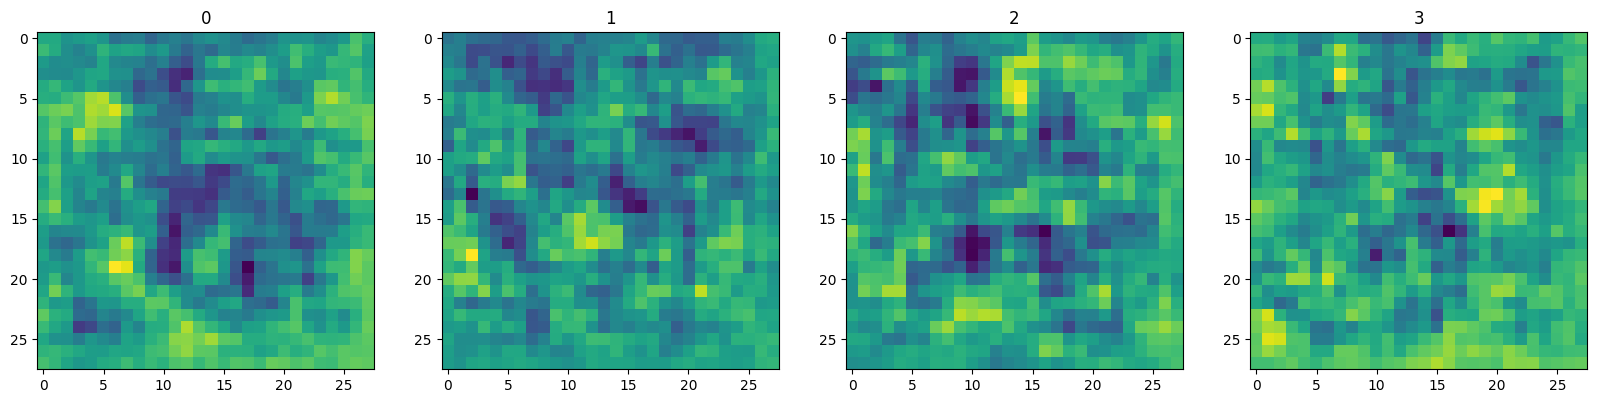

In [97]:
# generate new fashion
img = generator.predict(np.random.randn(4, 128, 1))

fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx, img in enumerate(img):
  # plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(img))
  # appending the image label as the plot title
  ax[idx].title.set_text(idx)

### 3.3 Build discriminator

In [98]:
def build_discriminator():
  model = Sequential()

  # first conv block
  model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # second conv block
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # third conv block
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # fourth conv block
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # flatten then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [99]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_56 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_18 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_54 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_57 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_19 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_55 (Conv2D)          (None, 16, 16, 128)     

In [100]:
img = generator.predict(np.random.randn(4, 128, 1))

1/1 [==============================] - 0s 23ms/step


In [101]:
img.shape

(4, 28, 28, 1)

In [102]:
discriminator.predict(img)

1/1 [==============================] - 0s 137ms/step


array([[0.49691105],
       [0.4968895 ],
       [0.49691007],
       [0.49678504]], dtype=float32)

In [103]:
img = img[0]
img.shape

(28, 28, 1)

In [104]:
discriminator.predict(np.expand_dims(img, 0))

1/1 [==============================] - 0s 29ms/step


array([[0.49691105]], dtype=float32)

## 4. Construct training loop

### 4.1 Setup losses and optimizers

In [105]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [106]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 build subclassed model

In [108]:
# importing the base model calss to subclass our training step
from tensorflow.keras.models import Model

In [109]:
tf.random.normal((6, 128, 1))

<tf.Tensor: shape=(6, 128, 1), dtype=float32, numpy=
array([[[-7.05539584e-01],
        [ 3.20392698e-01],
        [ 1.00658035e+00],
        [ 4.98254031e-01],
        [ 4.83972818e-01],
        [ 1.02737296e+00],
        [ 1.59521532e+00],
        [-8.54830444e-01],
        [ 7.97072768e-01],
        [-1.26698077e+00],
        [-7.35798478e-01],
        [ 2.21125460e+00],
        [-1.19208731e-01],
        [-6.92180336e-01],
        [-9.55520451e-01],
        [-6.77794695e-01],
        [-1.15175807e+00],
        [ 3.49603146e-01],
        [ 8.48533273e-01],
        [-4.51097131e-01],
        [-1.29506457e+00],
        [ 4.81640756e-01],
        [ 7.80529916e-01],
        [-1.13143206e+00],
        [-1.21638513e+00],
        [ 2.32854271e+00],
        [ 9.00227308e-01],
        [ 6.05567694e-01],
        [ 8.10350716e-01],
        [ 1.06273806e+00],
        [-3.14165473e-01],
        [-1.01721597e+00],
        [-2.36412096e+00],
        [-6.20919883e-01],
        [-3.02424490e-01],
  

In [ ]:
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)

    # create attributes for gen and disc
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    # compile with base class
    super().compile(*args, **kwargs)

    # create attributes for losses and optimizers
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss


  def train_step(self, batch):
    # get the data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128,128,1)), training=False)

    # train the discriminator
    with tf.GradientTape() as d_tape:
      # pass the real and fake images to the discriminator model
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      # create labels for real and fake imaged
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake), axis=0])

    # add some noise to the output
    # calculate loss
    # apply backprppagation - nn learn
    pass